# Image caption runs with various hyperparameters

### Time to get to loss 5.8 on DL

In [7]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [8]:
!ls logs/flextime/GTX_TITAN_X

loss5.8_20epoch loss5.8_50epoch


In [9]:
logdir = "logs/flextime/GTX_TITAN_X/loss5.8_50epoch"

In [10]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

180

In [11]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))                
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1
        if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
        df_epochtime.loc[0] = [batch,learn,run,epoch,time,loss]
        
    return (df_epochtime, df_validation)

In [12]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return (df_epochtime, df_validation)

In [13]:
print logdir
df_epochtime,df_validation = readLogs(logdir)

logs/flextime/GTX_TITAN_X/loss5.8_50epoch


In [14]:
print df_validation.shape
print df_epochtime.shape
df_validation.head()

(180, 9)
(180, 6)


,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12.0,0.0001,0.0,0.069234,0.033721,0.020298,0.013733,0.101530,0.032311
1,12.0,0.0001,1.0,0.070627,0.033100,0.019992,0.012976,0.110044,0.036901
2,12.0,0.0001,2.0,0.080488,0.042306,0.026034,0.017085,0.120394,0.039959
3,12.0,0.0005,0.0,0.220232,0.117457,0.071831,0.047150,0.202427,0.113442
4,12.0,0.0005,1.0,0.192612,0.113834,0.074965,0.051859,0.217379,0.118326


## Validation score

In [15]:
print df_validation.shape
df_validation.head()

(180, 9)


,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12.0,0.0001,0.0,0.069234,0.033721,0.020298,0.013733,0.101530,0.032311
1,12.0,0.0001,1.0,0.070627,0.033100,0.019992,0.012976,0.110044,0.036901
2,12.0,0.0001,2.0,0.080488,0.042306,0.026034,0.017085,0.120394,0.039959
3,12.0,0.0005,0.0,0.220232,0.117457,0.071831,0.047150,0.202427,0.113442
4,12.0,0.0005,1.0,0.192612,0.113834,0.074965,0.051859,0.217379,0.118326


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109dc7a10>]],
      dtype=object)

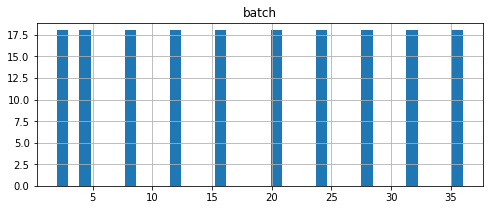

In [16]:
# Checking number of rows in the dataframe per batch size
# 6 LR values x 3 runs = 18 rows
plt.rcParams['figure.figsize'] = 8,3
df_validation[["batch"]].hist(bins=36)

In [17]:
# Take average between runs
df_mean = df_validation.groupby(["batch","lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,2.0,0.0001,0.163093,0.090439,0.056769,0.037441,0.216771,0.027740
1,2.0,0.0005,0.314820,0.171101,0.105391,0.068633,0.277851,0.029392
2,2.0,0.0010,0.264775,0.163931,0.111619,0.077219,0.249698,0.032670
3,2.0,0.0020,0.345634,0.242893,0.187268,0.136314,0.329016,0.022480
4,2.0,0.0030,0.010207,0.000416,0.000011,0.000002,0.128518,0.000396


### Remove batch size 2 (not usable)

In [18]:
df_mean = df_mean[df_mean["batch"] != 2]
df_mean.head()

,batch,lr,bleu1,bleu2,bleu3,bleu4,rouge,cider
6,4.0,0.0001,0.110562,0.057907,0.036707,0.024024,0.146748,0.038614
7,4.0,0.0005,0.342232,0.231092,0.168757,0.124244,0.322849,0.120890
8,4.0,0.0010,0.369715,0.256207,0.194861,0.146963,0.328420,0.114799
9,4.0,0.0020,0.273736,0.187504,0.140626,0.104430,0.248564,0.068976
10,4.0,0.0030,0.255120,0.176403,0.129539,0.095310,0.259934,0.058573


In [19]:
df_cider = df_mean.pivot_table(index="batch",columns="lr",values="cider")
df_rouge = df_mean.pivot_table(index="batch",columns="lr",values="rouge")
df_blue1 = df_mean.pivot_table(index="batch",columns="lr",values="bleu1")
df_blue2 = df_mean.pivot_table(index="batch",columns="lr",values="bleu2")
df_blue3 = df_mean.pivot_table(index="batch",columns="lr",values="bleu3")
df_blue4 = df_mean.pivot_table(index="batch",columns="lr",values="bleu4")
df_cider.head()

lr,0.0001,0.0005,0.001,0.002,0.003,0.004
batch,,,,,,
4.0,0.038614,0.120890,0.114799,0.068976,0.058573,0.018164
8.0,0.064974,0.086274,0.142787,0.111300,0.093876,0.083766
12.0,0.036390,0.123073,0.146850,0.126556,0.115343,0.120396
16.0,0.032786,0.121405,0.124887,0.164775,0.129700,0.133464
20.0,0.028041,0.128079,0.133021,0.182173,0.166802,0.116732


In [20]:
def plotHeatMap(df,ax,title=None,cmap=None):        
    cmesh=ax.pcolormesh(df,cmap=cmap)
    fig.colorbar(mappable=cmesh,ax=ax)    
    ax.set_yticks(np.arange(0.5, len(df.index), 1))
    ax.set_yticklabels(df.index)
    ax.set_xticks(np.arange(0.5, len(df.columns), 1))
    ax.set_xticklabels(df.columns)
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                ax.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.3, 'pad':0})
    ax.set_title(title,fontsize=18)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


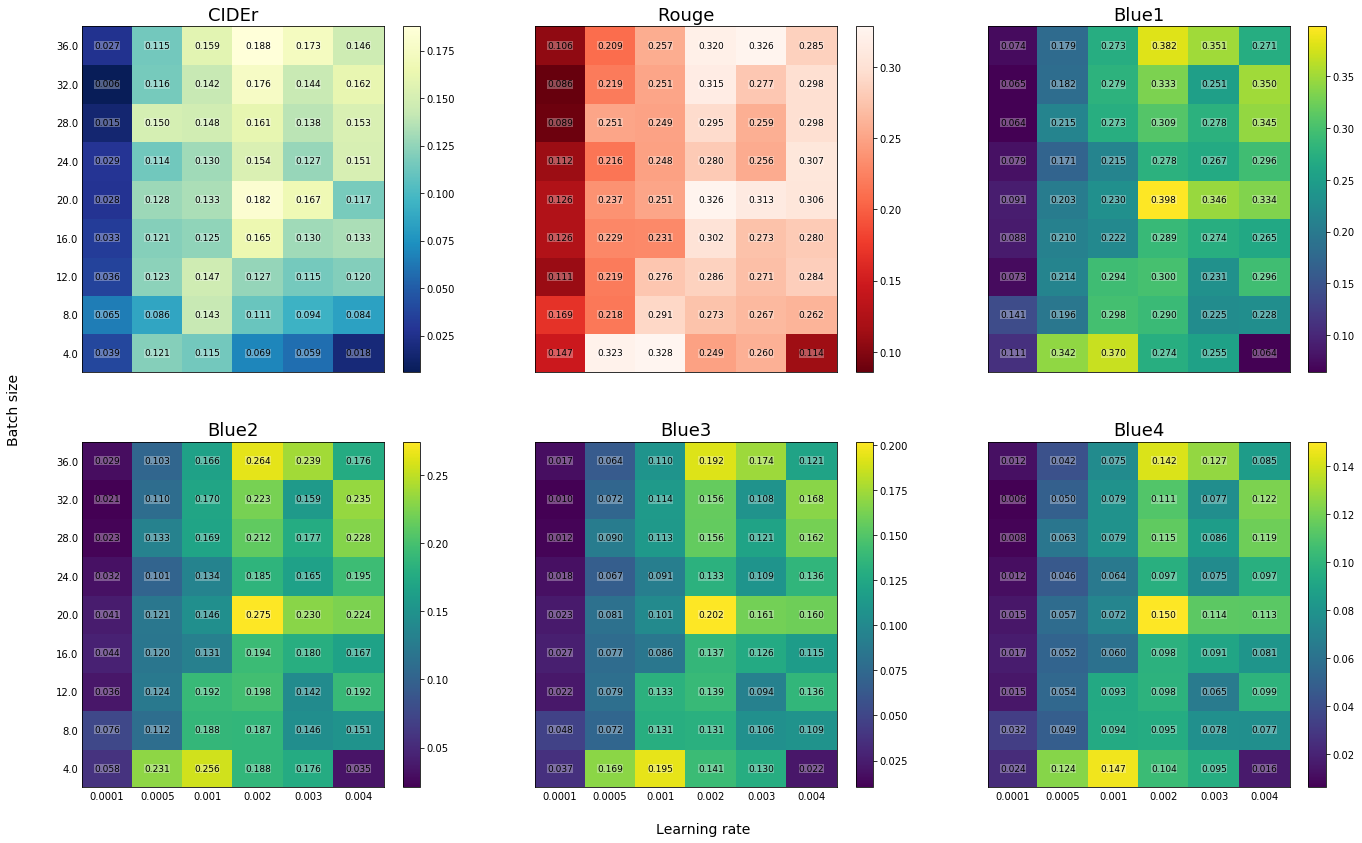

In [21]:
plt.rcParams['figure.figsize'] = 23,14
fig, ax = plt.subplots(2,3,sharex=True,sharey=True)
plotHeatMap(df_cider,ax[0,0],"CIDEr","YlGnBu_r")
plotHeatMap(df_rouge,ax[0,1],"Rouge","Reds_r")
plotHeatMap(df_blue1,ax[0,2],"Blue1")
plotHeatMap(df_blue2,ax[1,0],"Blue2")
plotHeatMap(df_blue3,ax[1,1],"Blue3")
plotHeatMap(df_blue4,ax[1,2],"Blue4")
fig.text(0.5, 0.08, 'Learning rate', ha='center',fontsize=14)
fig.text(0.08, 0.5, 'Batch size', va='center', rotation='vertical',fontsize=14)
fig.show()

## Loss and time

In [22]:
df_epochtime = df_epochtime[df_epochtime["batch"]!=2]
df_epochtime.head()

,batch,lr,run,epoch,time,loss
0,12.0,0.0001,0.0,50.0,615.964090,5.939202
1,12.0,0.0001,1.0,50.0,603.321938,6.189989
2,12.0,0.0001,2.0,50.0,611.076817,6.005225
3,12.0,0.0005,0.0,23.0,274.882946,5.752040
4,12.0,0.0005,1.0,34.0,415.970045,5.657025


In [23]:
# Take average between runs
df_mean = df_epochtime.groupby(["batch","lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,epoch,time,loss
0,4.0,0.0001,44.000000,831.681863,5.753189
1,4.0,0.0005,25.333333,474.035744,5.654566
2,4.0,0.0010,33.666667,633.263056,5.767122
3,4.0,0.0020,35.666667,687.358569,5.718776
4,4.0,0.0030,41.333333,805.696499,6.035190


In [24]:
loss_df = df_mean[['batch','lr','loss']]
time_df = df_mean[['batch','lr','time']]
epoch_df = df_mean[['batch','lr','epoch']]

In [25]:
def plotHeatMap(df,title=None,cmap=None):
    plt.rcParams['figure.figsize'] = 10,8 
    plt.pcolormesh(df,cmap=cmap)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    ax = plt.gca()
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                plt.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.2, 'pad':0})
    plt.title(title,fontsize=18)
    plt.xlabel("learning rate",fontsize=12)
    plt.ylabel("minibatch size",fontsize=12)
    plt.colorbar()
    plt.show()

In [26]:
loss_T = loss_df.pivot_table(index="batch",columns="lr",values="loss")
time_T = time_df.pivot_table(index="batch",columns="lr",values="time")
epoch_T = epoch_df.pivot_table(index="batch",columns="lr",values="epoch")

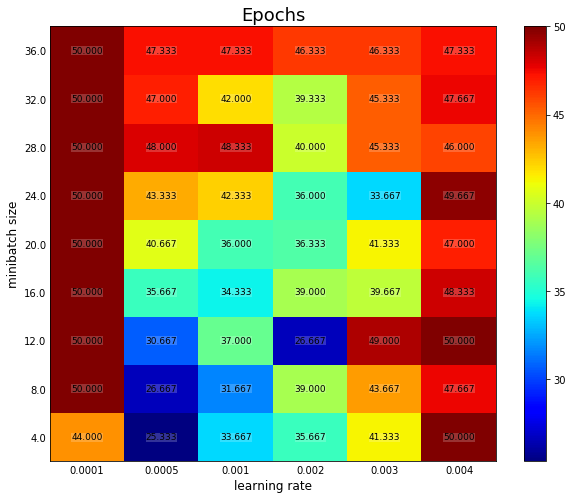

In [27]:
plotHeatMap(epoch_T,"Epochs","jet")

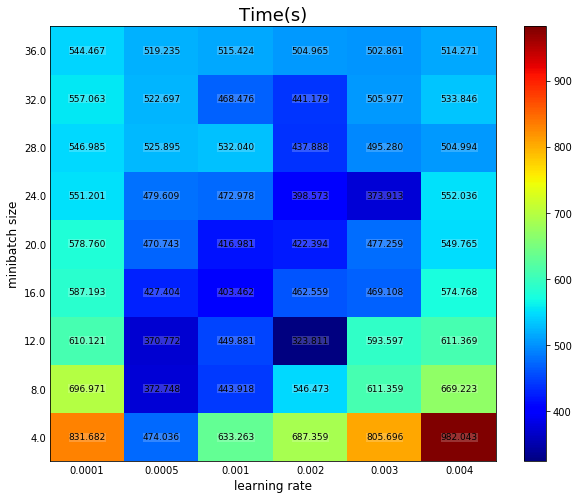

In [28]:
plotHeatMap(time_T,"Time(s)","jet")

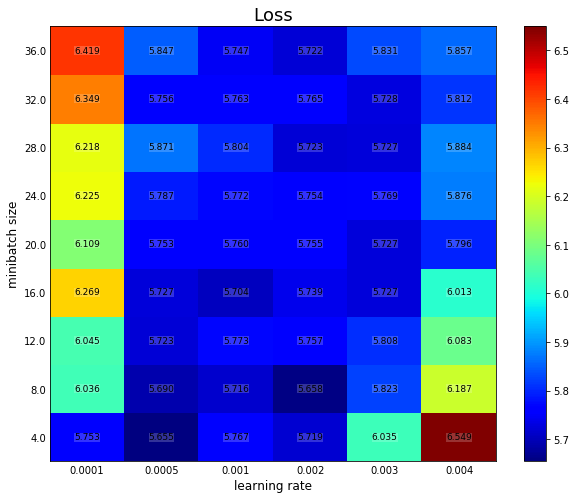

In [29]:
plotHeatMap(loss_T,"Loss","jet")

## Plot Loss graphs for each BS x LR combinations

In [36]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDFwEpochs(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0 # DataFrame row number (index)
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))                
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df_epochtime.loc[ind] = [batch,learn,run,epoch,time,loss]
                ind += 1
        
    return df_epochtime

In [37]:
def readEpochLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    
    filecounter=0
    for file in files:
        if debug: print file
        df_e1 = fileToDFwEpochs(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return df_epochtime

In [38]:
print logdir
df_epochtime = readEpochLogs(logdir)

logs/flextime/GTX_TITAN_X/loss5.8_50epoch


In [39]:
df_epochtime.head()

,batch,lr,run,epoch,time,loss
0,12.0,0.0001,0.0,1.0,13.052544,7.266699
1,12.0,0.0001,0.0,2.0,25.208029,6.840775
2,12.0,0.0001,0.0,3.0,37.394306,7.203015
3,12.0,0.0001,0.0,4.0,49.734088,6.773653
4,12.0,0.0001,0.0,5.0,62.184238,6.823152


In [41]:
# Take average between runs
df_mean_epo = df_epochtime.groupby(["batch","lr","epoch"]).mean().reset_index().drop(["run"],axis=1)
df_mean_epo[(df_mean_epo["batch"] == 4.) & (df_mean_epo["lr"] == 0.001)].head()

,batch,lr,epoch,time,loss
354,4.0,0.001,1.0,19.552902,6.846049
355,4.0,0.001,2.0,38.171448,6.841329
356,4.0,0.001,3.0,56.655240,6.802682
357,4.0,0.001,4.0,75.313780,6.764478
358,4.0,0.001,5.0,93.920459,6.702109


In [43]:
df_mean_epo = df_mean_epo.sort_values(by=["batch","lr","epoch"],ascending=True)
df_mean_epo.head(5)

,batch,lr,epoch,time,loss
0,2.0,0.0001,1.0,30.359871,6.899429
1,2.0,0.0001,2.0,60.145263,6.831204
2,2.0,0.0001,3.0,89.779174,6.264756
3,2.0,0.0001,4.0,119.427876,6.864680
4,2.0,0.0001,5.0,148.863853,6.408946


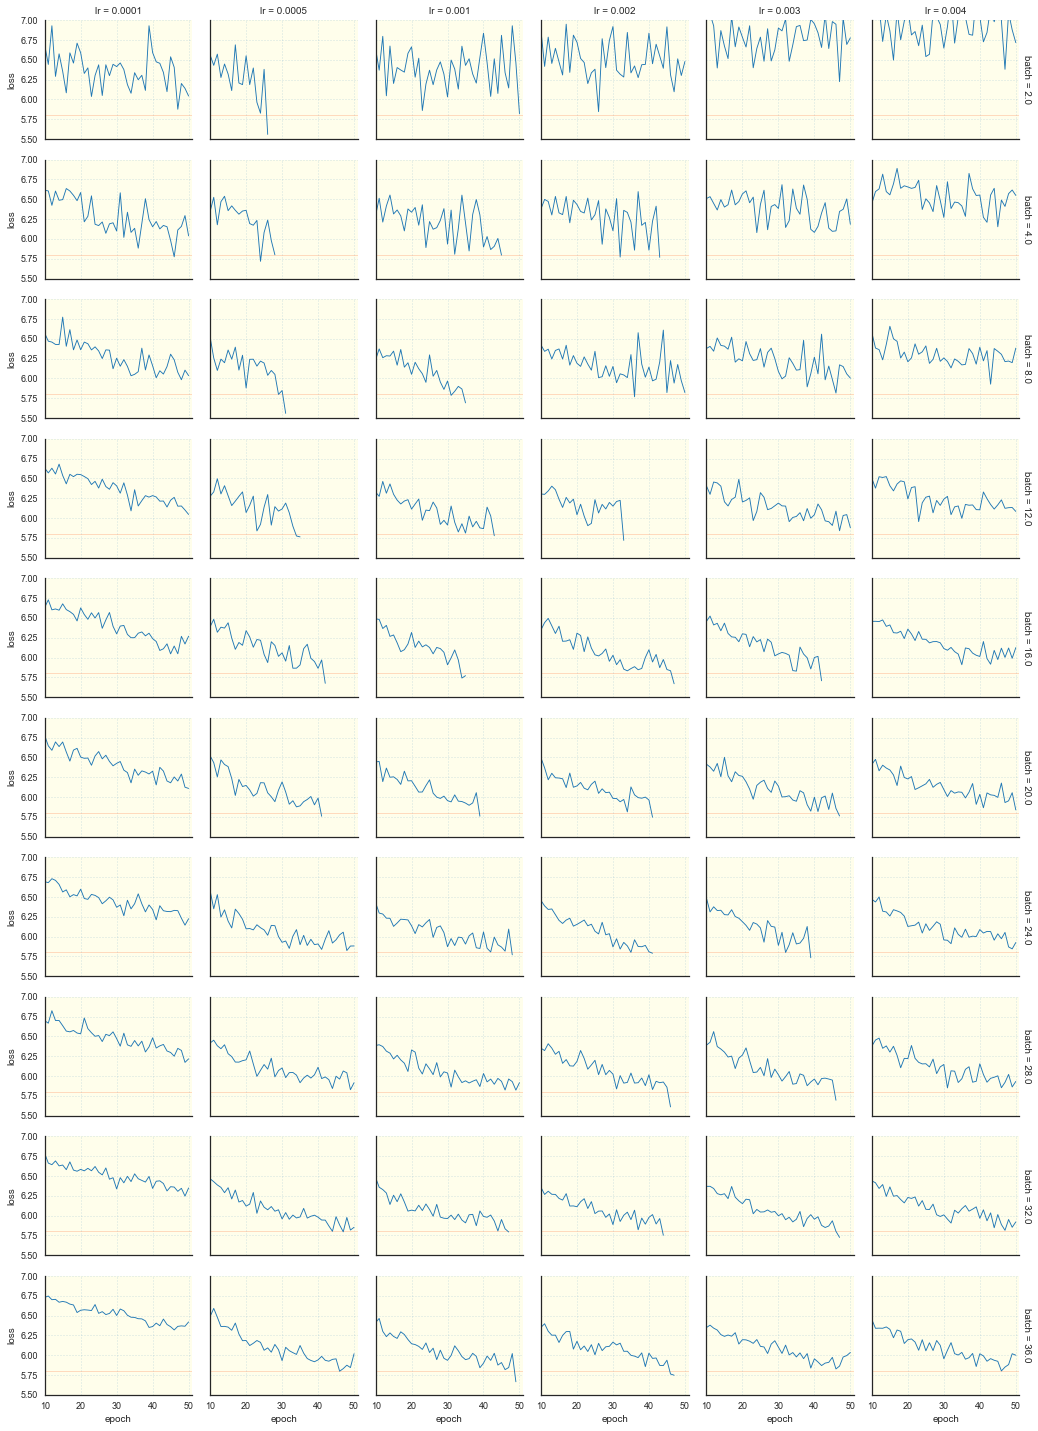

In [51]:
# Plot using Seaborn FacetGrid
# Set Seaborn global parameters
sns.set(font_scale=0.9)
sns.set_style("white",{'axes.grid': True, 'grid.color': (0,0,0),'grid.linestyle':u':'})
#print sns.axes_style()

# Plot using "tab10" matplotlib colormap
with sns.color_palette("tab10"):
    fg = sns.FacetGrid(df_mean_epo,row="batch",col="lr",size=2,aspect=1.2,
                         row_order=df_mean_epo.batch.unique(),
                         xlim=(10,51),
                         ylim=(5.5,7.),
                         margin_titles=True,
                         subplot_kws={"facecolor":"#FFFEEB"})
    fg.map(plt.axhline,y=5.8,ls="-",c="#ff8855",linewidth=1,alpha=.3)
    #fg.set(xticks=np.arange(50,101,10))
    #fg.set(yticks=np.arange(0.5,0.66,.05))
    fg.map(plt.grid,ls=":",alpha=.1,linewidth=1,aa=False)
    fg.map(plt.plot,"epoch","loss",ls="-",linewidth=.9)

